## INSTALL PACKAGES

Only the package `pyaocs` (specifically developed for this competition) needs to be installed:
`pip install pyaocs`

In [1]:
!pip install pyaocs


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## IMPORT PACKAGES

In [2]:
import numpy as np
from pyaocs import parameters as param
from pyaocs.simulation import digital_twin
import pickle

## CREATE CONTROL CLASS

# Control Class

A control class is a fundamental part of this system. It must contain the following methods:

## `__init__` Method

This is the initializer method where variables are initialized if required.

## `compute` Method

The `compute` method takes an `obs` object as input. The `obs` object is a dictionary with the following structure:

```python
    obs = {
        "current_position": np.array(position),
        "current_orientation": np.array(orientation),
        "target_position": np.array(target_position),
        "target_orientation": np.array(target_orientation),
        "current_velocity": np.array(velocity),
        "parameters": np.array(parameters)
    }
```

Each key in the `obs` dictionary represents a different aspect of the system's state, and the values are numpy arrays representing the state of that aspect.

The `compute` method must return an `action` object. The `action` object is a numpy array with the following structure:
```python
    action = np.array([F1, 0, 0, 0, δ1, 0])
```
Where:

-   `F1` represents the state of the thruster. When `F1` is `0`, the thruster is OFF. When `F1` is `1`, the thruster is ON.
-   `δ1` represents the angle parallel to the microgravity table. It can range from `-16` to `16` degrees.

Due to the actual platform having more control options, the `action` object contains 6 inputs. Only `F1` (in index 0) and `δ1` (in index 4) are important for this competition, so keep the other entries as 0.

## `plot` Method
It can be left as `pass` if nothing wants to be plotted. But if anything is plotted here, it will automatically plot at the end of the simulation. It may be useful for debugging purposes.

Here is an example class that just fires the thruster for 1s, without any control.

In [35]:
class SimpleTestControl():

    def __init__(self):
        self.firing_time = 2 #s

        self.dt = 1 / param.sample_rate

        self.total_steps = self.firing_time / self.dt

        self.step = 0

    def compute(self, obs):

        F1 = 0
        δ1 = 0

        if (self.step + 1) <= self.total_steps:
            F1 = 1

        action = np.array([F1, 0, 0, 0, δ1, 0])

        self.step += 1

        return action
    
    def plot(self):
        pass

## RUN SIMULATION

The digital twin has the structure shown in the following image:

<img src="media/Satellite_Convention-Repository Structure.drawio.png" width="800">

The `control class` that we are making and this competition consists on developing the `AOCS Control` block. All the other aspects are automatically handled by the package `pyaocs`. Running the feedback loop with the simulation and the `control class` is very easy:

Mass of satellite: 10 kg
FPS: 630.9112


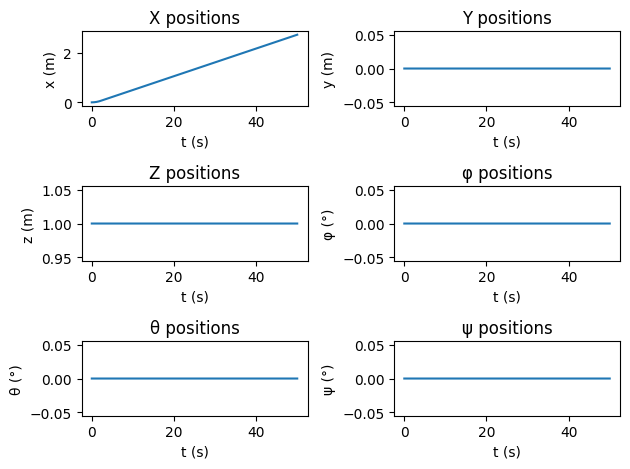

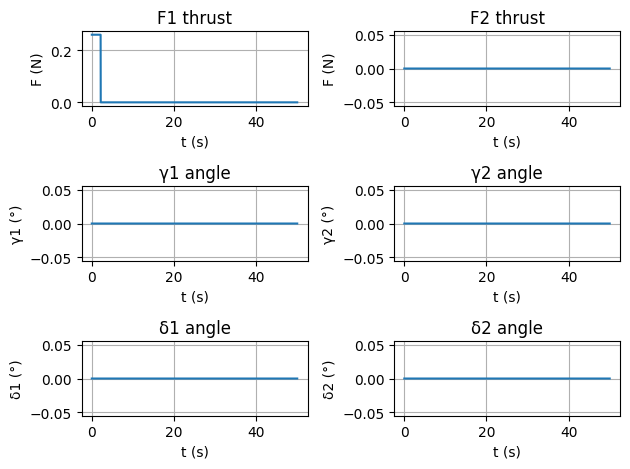

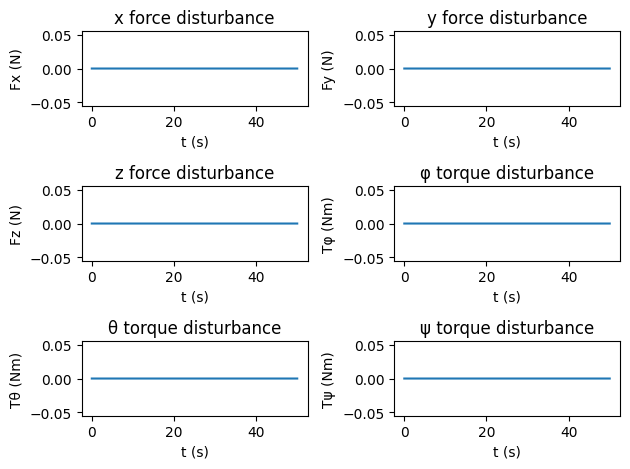

Total firing time: 2.15 s


In [36]:
strategy = SimpleTestControl()

env, _, _ = digital_twin.run(strategy, 
                             render=True, 
                             real_time=False, 
                             use_disturbances=False,
                             noise=False)

## Competition Scoring Categories

The competition will have three scoring categories:

1. **Ideal World**: In this category, no disturbances or sensor noise are added to the simulation. This represents an ideal world scenario where everything operates as expected without any external factors causing variations.

2. **Disturbances Added**: In this category, disturbances are added to the simulation. This represents a more realistic scenario where external factors can cause variations in the operation of the system.

3. **Disturbances and Noise Added**: In this category, both disturbances and sensor noise are added to the simulation. This represents a highly realistic and challenging scenario where both external factors and sensor noise can cause variations in the operation of the system.

Make sure your control strategy can deal with disturbances and noise, as the third category will determine whose control strategy is tested in ESA ESTEC and represents the most realistic scenario.

## `digital_twin.run()` Input Options

- **strategy**: This is the control class that implements the control logic for the simulation. It should have a `compute()` method defined, which takes an `obs` object as input and returns an `action` object.

- **render**: This option determines whether to render the simulation. If set to `True`, the simulation will be visualized. If set to `False`, no visualization will be shown.

- **real_time**: This option determines whether to run the simulation in real-time or not. If set to `True`, the simulation will run in real-time, meaning that the time in the simulation will progress at the same rate as the real-world time. If set to `False`, the simulation will run as fast as possible.

- **use_disturbances**: This option determines whether to include disturbances in the simulation. If set to `True`, disturbances will be included. If set to `False`, no disturbances will be included.

- **noise**: This option determines whether to add sensor noise to the simulation. If set to `True`, noise will be added. If set to `False`, no noise will be added.

Note that the competition will have 3 categories. 

# SCORING

In [38]:
def scoring(env):
    position_error = np.mean(np.abs((np.array(env.actual_positions) - np.array(env.target_positions))))
    orientation_error = 0

    firing_time = np.sum(np.array(env.F1s) / param.F) / param.fps

    score = 400*position_error + orientation_error + firing_time

    print(f"Position error: {position_error} m")
    print(f"Firing time: {firing_time} s")
    print(f"Score: {score}")

    return score

score = scoring(env)

Position error: 0.9516199209683359 m
Firing time: 2.15 s
Score: 382.7979683873343


In [23]:
param.fps

240

# SUBMISSION

Now let's save the control class into a pickle object:

In [39]:
path = "submissions/example_submission.pkl"

Substitute `SimpleTestControl()` by the name of your control class

In [40]:
import cloudpickle

p = cloudpickle.dumps(SimpleTestControl())
with open(path, "wb") as f:
    f.write(p)

Load it again to verify it was downloaded correctly:

In [41]:
with open(path, "rb") as f:
    strategy = cloudpickle.load(f)

If pickle file loaded correctly, you should be able to run the simulation again:

Mass of satellite: 10 kg
FPS: 1923.995


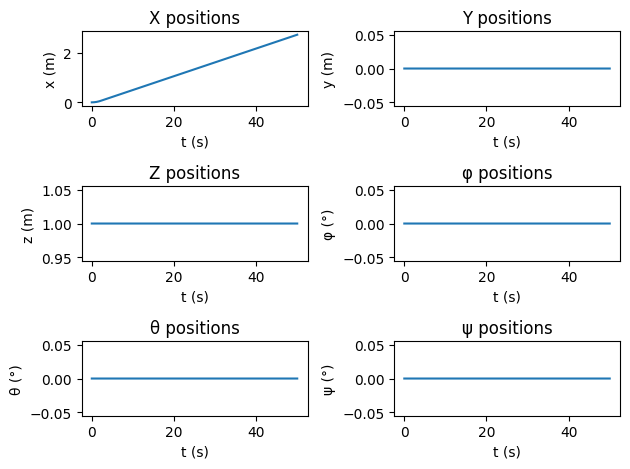

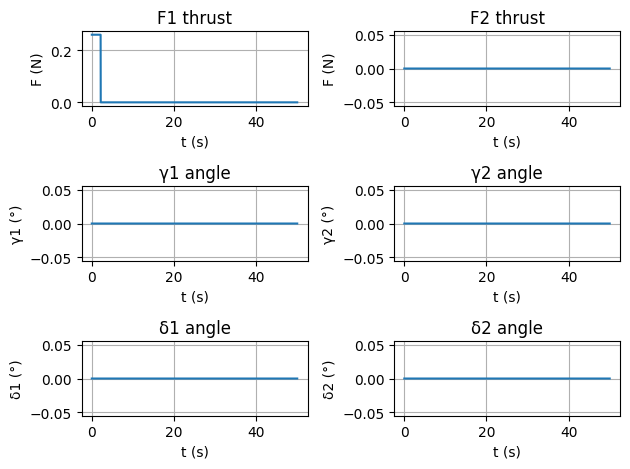

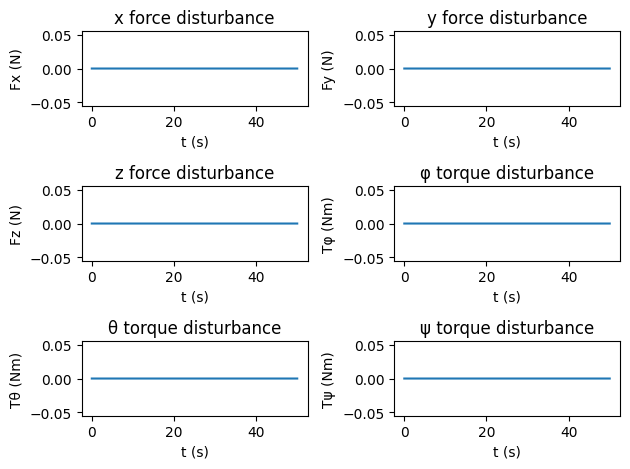

Total firing time: 2.15 s


(<pyaocs.simulation.environment.SatelliteEnv at 0x1e61fde5810>,
 {'current_position': array([2.73502396, 0.        , 1.        ]),
  'current_orientation': array([0., 0., 0., 1.]),
  'target_position': array([2, 2, 1]),
  'target_orientation': array([0, 0, 0]),
  'current_velocity': array([0.0559, 0.    , 0.    ]),
  'parameters': array([0., 0., 0., 0., 0., 0.])},
 <__main__.SimpleTestControl at 0x1e67f59c250>)

In [42]:
digital_twin.run(strategy, 
                render=True, 
                real_time=False, 
                use_disturbances=False,
                noise=False)